In [33]:
from google.cloud import storage
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
from wordcloud import WordCloud
%matplotlib inline

In [9]:
sns.set_style('darkgrid')

In [10]:
REGION = 'us-central1'
#Get Project ID
project = !gcloud config get-value project
PROJECT_ID = project[0]
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'yelp'
bq_dir = BQ_PROJECT + '.'+BQ_DATASET
print('BigQuery project ID:', BQ_PROJECT)
print('BigQuery dataset:', BQ_DATASET)
print('BiqQuery dataset directory:', bq_dir)
#Set clients:
gcs = storage.Client(project = PROJECT_ID)
bq = bigquery.Client(project = PROJECT_ID)


BigQuery project ID: valiant-song-371916
BigQuery dataset: yelp
BiqQuery dataset directory: valiant-song-371916.yelp


In [11]:
### Get the list of tables from the dataset yelp:
dataset_id = BQ_DATASET
tables = bq.list_tables(dataset_id)  # Make an API request.

print("Tables contained in '{}':".format(dataset_id))
for table in tables:
    print("{}.{}.{}".format(table.project, table.dataset_id, table.table_id))


Tables contained in 'yelp':
valiant-song-371916.yelp.business
valiant-song-371916.yelp.checkin
valiant-song-371916.yelp.reviews
valiant-song-371916.yelp.tip
valiant-song-371916.yelp.user


In [12]:
bq_dir = BQ_PROJECT + '.'+BQ_DATASET
bq_dir

'valiant-song-371916.yelp'

In [13]:
### Get the first 5 instances from business table:
query = f"""
            SELECT *
            FROM {bq_dir}.business
            LIMIT 5
    """
business = bq.query(query = query).to_dataframe()


In [20]:
business.head()

,categories,attributes,state,is_open,postal_code,name,review_count,hours,stars,latitude,address,longitude,city,business_id
0,"Real Estate Agents, Home Services, Real Estate",None,IN,1,46032,Jennie Deckert,7,None,5.0,39.969300,,-86.165002,Carmel,REwfwz-_-CMQ7Np5UVi9Qg
1,"Banks & Credit Unions, Financial Services",None,DE,1,19850,Chase JP Morgan Bank Credit Card Services,111,None,1.5,39.749361,,-75.643331,Wilmington,7PDi_iyik3jraDAzWwwR4Q
2,"Couriers & Delivery Services, Local Services, ...",None,TN,1,37027,Nashville Delivers,7,None,3.5,36.002397,6591 Bluff Rd,-86.702381,Brentwood,qFX8IdomeBVhDPCSyz2aRg
3,"Banks & Credit Unions, Financial Services",None,PA,1,19083,TD Bank Havertown,6,None,1.5,39.985661,120 W Eagle Rd,-75.314844,Haverford,FC6ef4rMMZKNov_-A9M6iQ
4,"Gas Stations, Automotive, Towing",None,NJ,1,08057,Lott's Service,8,None,1.5,39.973753,"908 N Lenola Rd, Ste 3",-74.995949,Moorestown,DcUDIlxFsvqPvFh8_lb4Sw


In [9]:
#column of business: 
business.columns

Index(['categories', 'attributes', 'state', 'is_open', 'postal_code', 'name',
       'review_count', 'hours', 'stars', 'latitude', 'address', 'longitude',
       'city', 'business_id'],
      dtype='object')

### Get the top ten cities with the most business in yelp and still open

In [26]:
### Get the top ten cities with the most business in yelp:
query = f"""
            SELECT city,
                    count(business_id) as total_business, 
                    SUM(CASE 
                        WHEN is_open = 1 THEN 1
                        Else 0 
                    END) AS total_open
            FROM {bq_dir}.business
            GROUP BY city
            ORDER BY total_business DESC, total_open DESC
            LIMIT 10
    """
top10city = bq.query(query = query).to_dataframe()
top10city

,city,total_business,total_open
0,Philadelphia,14563,10537
1,Tucson,9248,7533
2,Tampa,9050,7219
3,Indianapolis,7537,5892
4,Nashville,6967,5394
5,New Orleans,6207,4647
6,Reno,5934,4761
7,Edmonton,5049,3912
8,Saint Louis,4823,3401
9,Santa Barbara,3828,3019


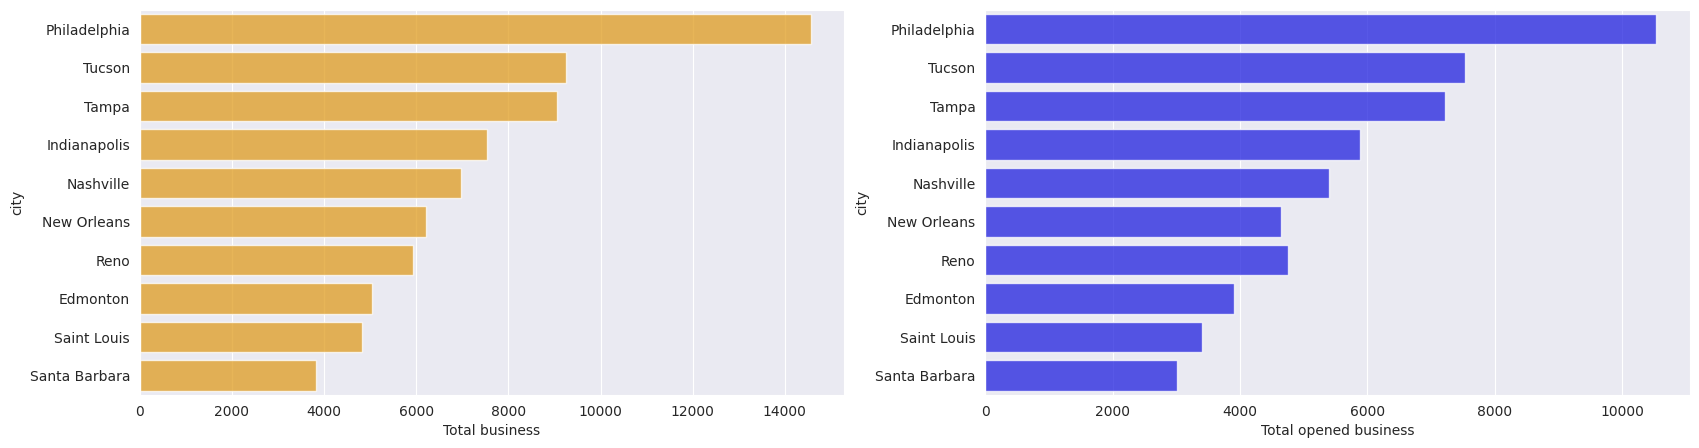

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
sns.barplot(data = top10city, x = 'total_business', y = 'city', color ='orange', alpha = 0.75,ax=axs[0])
sns.barplot(x="total_open", y="city", data=top10city, color = 'blue', alpha = 0.75, ax=axs[1])

axs[0].set_xlabel("Total business")
axs[1].set_xlabel("Total opened business")
plt.show()

### Get the open businesses with most review in Philadelphia

In [74]:
query = f"""
            SELECT categories, 
                    latitude,
                    longitude,
                    review_count
            FROM {bq_dir}.business
            WHERE city = 'Philadelphia'
            AND is_open = 1
            ORDER BY review_count DESC
            LIMIT 100
    """
business_phil = bq.query(query = query).to_dataframe()
business_phil.head()

,categories,latitude,longitude,review_count
0,"Candy Stores, Shopping, Department Stores, Fas...",39.953341,-75.158855,5721
1,"Italian, American (Traditional), Sandwiches, F...",39.933201,-75.159266,4250
2,"Sandwiches, Cheesesteaks, Steakhouses, Restaur...",39.933837,-75.158814,3401
3,"Lounges, Bars, Nightlife, Breakfast & Brunch, ...",39.949702,-75.161770,3187
4,"Nightlife, Bars, Food, Ethnic Food, Middle Eas...",39.946261,-75.145135,3065


Many businesses with high review counts are located in the downtown area of Philadelphia. The top five businesses with highest reviews are Department Store, Restaurants and Bars.

In [70]:
import folium

# Create map object
map = folium.Map(location=[39.9526, -75.1652], zoom_start=10)

# Create a ColorMap object to map the "review_count" column to colors
color_map = folium.LinearColormap(colors=["green", "yellow", "red"], vmin=business_phil["review_count"].min(), vmax=business_phil["review_count"].max())

# Add data points to map
business_phil.apply(lambda row: folium.Marker(location=[row["latitude"], row["longitude"]], 
                                              icon=folium.Icon(color=color_map(row["review_count"])), 
                                              popup=row["categories"], tooltip=row["categories"]).add_to(map), axis=1)

# Add color legend
color_map.add_to(map)

# Show map
map

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning:

color argument of Icon should be one of: {'lightgreen', 'cadetblue', 'black', 'green', 'darkgreen', 'darkred', 'lightblue', 'lightgray', 'pink', 'darkblue', 'beige', 'darkpurple', 'orange', 'white', 'lightred', 'purple', 'gray', 'blue', 'red'}.



### Get the business that is close but with the least reviews in Philadelphia

In [67]:
query = f"""
            SELECT categories, 
                    latitude,
                    longitude,
                    review_count
            FROM {bq_dir}.business
            WHERE city = 'Philadelphia'
            AND is_open = 0
            ORDER BY review_count ASC
            LIMIT 100
    """
close_business_phil = bq.query(query = query).to_dataframe()
close_business_phil.head()

,categories,latitude,longitude,review_count
0,"American (New), Breakfast & Brunch, Restaurant...",40.009891,-75.190535,5
1,"Local Services, Self Storage",39.964133,-75.146819,5
2,"Fashion, Shopping, Women's Clothing, Accessories",39.878778,-75.242122,5
3,"Colleges & Universities, Education",40.040837,-75.157493,5
4,"Auto Repair, Automotive",40.035099,-75.044597,5


Businesses with low review counts are often located outside of downtown Philadelphia, and these businesses tend to be of different types

In [75]:
# Create map object
map = folium.Map(location=[39.9526, -75.1652], zoom_start=10)

# Create a ColorMap object to map the "review_count" column to colors
color_map = folium.LinearColormap(colors=["green", "yellow", "red"], vmin=business_phil["review_count"].min(), vmax=business_phil["review_count"].max())

# Add data points to map
close_business_phil.apply(lambda row: folium.Marker(location=[row["latitude"], row["longitude"]], 
                                              icon=folium.Icon(color=color_map(row["review_count"])), 
                                              popup=row["categories"], tooltip=row["categories"]).add_to(map), axis=1)

# Add color legend
color_map.add_to(map)

# Show map
map

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning:

color argument of Icon should be one of: {'lightgreen', 'cadetblue', 'black', 'green', 'darkgreen', 'darkred', 'lightblue', 'lightgray', 'pink', 'darkblue', 'beige', 'darkpurple', 'orange', 'white', 'lightred', 'purple', 'gray', 'blue', 'red'}.



### Get Business with most Five Star Reviews from Users

In [6]:
query = f"""
            SELECT *
            FROM {bq_dir}.reviews
            LIMIT 5
    """
reviews = bq.query(query = query).to_dataframe()
reviews.head()

,text,cool,stars,date,funny,review_id,useful,business_id,user_id
0,Overall this hotel isn't nearly as nice as oth...,0,2.0,2018-09-03 15:29:54+00:00,0,NmMLs3lFUSQK2KUzEJx8OA,0,85yx4a7CRJAQXkID6pWacA,o-Ce_h9kmWCeoDsz0osYwg
1,"I went here religiously for 3+ years, but unfo...",0,2.0,2019-03-24 16:28:08+00:00,0,hNxlfp-m92SQa-Wt_gVXSg,0,QUHXdH8vrJ6LSj3UxgeO8g,hCM8ioTTAvFyWD9G-UCmQg
2,Im 36 years old now and it is the same exhibit...,0,2.0,2014-07-23 15:38:39+00:00,0,tsyqFza4XPsbZykFSxTSug,0,yl6PUs7nEIxGCgubarhtpg,-EicltwG2eXNxcCc6Jf4Cg
3,"This was our first time trying Cal Taco, as we...",0,2.0,2011-07-28 19:29:56+00:00,0,ICaXkmUs0eLVEnVEkaaQRQ,0,VeFfrEZ4iWaecrQg6Eq4cg,l2IWzTJtrIlP_W9fHit1cA
4,So there isnt much great to say about this loc...,0,2.0,2015-04-16 14:45:22+00:00,0,Pvw_BEMmIc1M0iZB9baOGw,0,F_24wAKBIVdXEZY5ilNH9w,lPl009CgRixetKMwGu7h-Q


In [90]:
query = f"""
            SELECT b.name, 
                    SUM(CASE
                            WHEN r.stars = 5.0 THEN 1
                        ELSE 0
                        END) as five_stars
            FROM {bq_dir}.reviews as r
            JOIN {bq_dir}.business as b
            ON b.business_id = r.business_id
            WHERE b.city = 'Philadelphia'
            AND b.is_open = 1
            GROUP BY b.name
            ORDER BY five_stars DESC
            LIMIT 10
    """
top_bus_reviews = bq.query(query = query).to_dataframe()
top_bus_reviews

,name,five_stars
0,Reading Terminal Market,4014
1,Zahav,2282
2,Dalessandro’s Steaks & Hoagies,1595
3,Barbuzzo,1574
4,Parc,1320
5,Talula's Garden,1262
6,Han Dynasty,1255
7,Green Eggs Café,1248
8,Sabrina's Café,1226
9,Cafe La Maude,1160


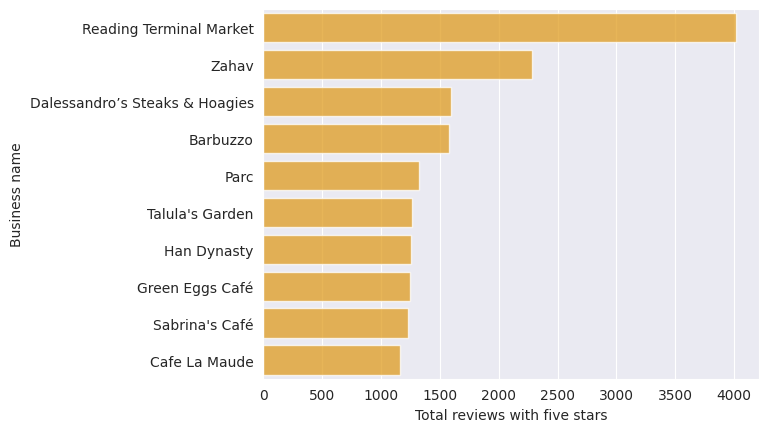

In [98]:
ax = sns.barplot(data = top_bus_reviews, x = 'five_stars', y = 'name', color ='orange', alpha = 0.75)
# Add text labels to each bar
plt.xlabel('Total reviews with five stars')
plt.ylabel('Business name')
plt.show()

### Get the quality of reviews for Reading Terminal Market

In [77]:
query = f"""
            SELECT b.name, 
                    r.useful,
                    r.funny,
                    r.cool,
                    r.stars                
            FROM {bq_dir}.reviews as r
            JOIN {bq_dir}.business as b
            ON b.business_id = r.business_id
            WHERE b.name = 'Reading Terminal Market'
    """
RTMarket = bq.query(query = query).to_dataframe()
RTMarket.head()

,name,useful,funny,cool,stars
0,Reading Terminal Market,0,0,0,2.0
1,Reading Terminal Market,0,0,0,2.0
2,Reading Terminal Market,0,0,0,2.0
3,Reading Terminal Market,1,0,0,2.0
4,Reading Terminal Market,3,0,2,2.0


In [78]:
RTMarket['useful']=RTMarket['useful'].apply(lambda x: 'above 5' if x>5 else x)

In [79]:
RTMarket['funny']=RTMarket['funny'].apply(lambda x: 'above 5' if x>5 else x)

In [80]:
RTMarket['cool']=RTMarket['cool'].apply(lambda x: 'above 5' if x>5 else x)

<AxesSubplot:xlabel='cool', ylabel='count'>

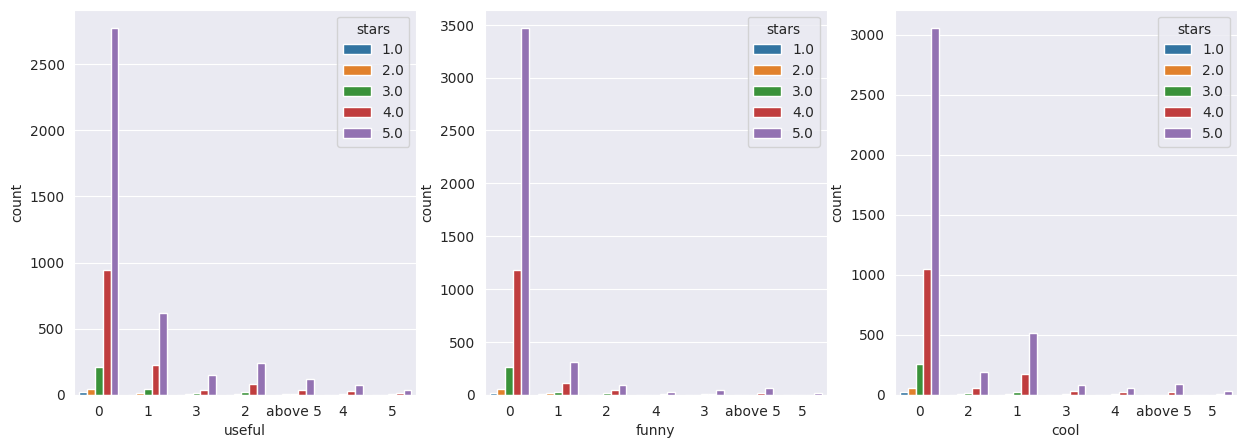

In [82]:
# Create a figure value_countsrows and 1 column, and set the size
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.countplot(data = RTMarket, x = 'useful', hue = 'stars',ax=ax[0])
sns.countplot(data = RTMarket, x = 'funny', hue = 'stars', ax = ax[1])
sns.countplot(data = RTMarket, x = 'cool', hue = 'stars', ax = ax[2])


Majority of the reviews for Reading Terminal Marketare not useful, funny or cool.

### Get the keywords for good reviews and bad reviews for Reading Terminal Market

Assumption:
* Good reviews will have rating above 4 and 5, and encode as 1
* Bad reviews will have rating below 3, and encode as 0


In [283]:
query = f"""
            SELECT  r.text,
                    CASE 
                        WHEN r.stars >=4 THEN 1
                        ELSE 0
                    END as rating_label    
            FROM {bq_dir}.reviews as r
            JOIN {bq_dir}.business as b
            ON b.business_id = r.business_id
            WHERE b.name = 'Reading Terminal Market'
            AND (r.stars<3 OR r.stars >=4)
    """
RTMarket_rating = bq.query(query = query).to_dataframe()
RTMarket_rating.head()

,text,rating_label
0,"Lines, long lines, nothing but lines. Keep in ...",0
1,Good location. Very friendly staff. Horrible w...,0
2,My only complain with this place is that it cl...,1
3,"If you are going to Philly, DON'T SKIP THIS! T...",1
4,The Reading terminal is a place that you could...,1


In [284]:
RTMarket_rating.shape

(5474, 2)

#### Monogram analysis

In [25]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

stopwords = nltk.corpus.stopwords.words('english')+ ['reading','terminal','market']
punctuation_regex = re.compile(r'[^\w\s]')

def tokenize_words(text,stopwords, punctuation_regex):
    filtered_words =[]
    # Tokenize the text into individual words
    words = word_tokenize(text)
    for word in words:
        if word.lower() not in stopwords and not punctuation_regex.match(word):
            filtered_words.append(lemmatizer.lemmatize(word))
    return filtered_words


In [286]:
RTMarket_rating['processed_text']=RTMarket_rating['text'].apply(lambda x: tokenize_words(x,stopwords,punctuation_regex))
RTMarket_rating.head()

,text,rating_label,processed_text
0,"Lines, long lines, nothing but lines. Keep in ...",0,"[Lines, long, line, nothing, line, Keep, mind,..."
1,Good location. Very friendly staff. Horrible w...,0,"[Good, location, friendly, staff, Horrible, wi..."
2,My only complain with this place is that it cl...,1,"[complain, place, close, early, get, best, dea..."
3,"If you are going to Philly, DON'T SKIP THIS! T...",1,"[going, Philly, N'T, SKIP, Try, Philly, cheese..."
4,The Reading terminal is a place that you could...,1,"[place, could, find, lost, four, hour, walk, f..."


In [28]:
from collections import Counter
def get_word_counter(list_of_texts):
    word_freq= {}
    for line in list_of_texts:
        counter = Counter(line)
        for word in counter.keys():
            if word not in word_freq:
                word_freq[word]=1
            else:
                word_freq[word]+=1
    return word_freq

def get_two_wordCloud(df1,df2, df1_title, df2_title):
    # Create a WordCloud object for the first set of words
    wordcloud_1 = WordCloud(width=400, height=200)

    # Generate a word cloud from the dictionary
    wordcloud_1.generate_from_frequencies(df1)

    # Create a WordCloud object for the second set of words
    wordcloud_2 = WordCloud(width=400, height=200)

    # Generate a word cloud from the dictionary
    wordcloud_2.generate_from_frequencies(df2)

    # Create a new figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

    # Display the first word cloud in the first subplot
    ax1.imshow(wordcloud_1, interpolation='bilinear')
    ax1.axis("off")

    # Add a title to the first subplot
    ax1.set_title(df1_title)

    # Display the second word cloud in the second subplot
    ax2.imshow(wordcloud_2, interpolation='bilinear')
    ax2.axis("off")

    # Add a title to the second subplot
    ax2.set_title(df2_title)

    plt.show()


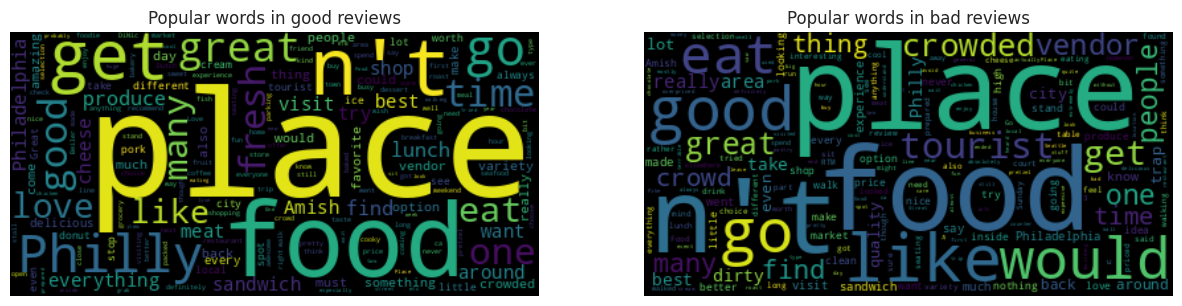

In [304]:
# Get the texts of bad and good reviews separately
bad_reviews=RTMarket_rating[RTMarket_rating['rating_label'] ==0]['processed_text']
good_reviews = RTMarket_rating[RTMarket_rating['rating_label'] ==1]['processed_text']

# Convert text in each reviews to single words (monograms) and obtain its frequency
bad_reviews_words = get_word_counter(bad_reviews)
good_reviews_words = get_word_counter(good_reviews)

# Visualize the popular words in good and bad reviews using wordcloud
get_two_wordCloud(good_reviews_words,bad_reviews_words,
                  'Popular words in good reviews',
                 'Popular words in bad reviews')

In [290]:
import heapq

# Get the top 10 highest values from the dictionary
top_10_good_words = heapq.nlargest(10, good_reviews_words.items(), key=lambda x: x[1])
top_10_bad_words = heapq.nlargest(10, bad_reviews_words.items(), key=lambda x: x[1])

# Print the top 10 values
print(top_10_good_words)
print(top_10_bad_words)

[('place', 3221), ('food', 2759), ("n't", 1529), ('get', 1480), ('Philly', 1376), ('go', 1334), ('great', 1295), ('good', 1214), ('time', 1168), ('one', 1096)]
[('place', 49), ('food', 47), ("n't", 39), ('like', 29), ('go', 25), ('good', 24), ('would', 23), ('eat', 21), ('tourist', 21), ('get', 20)]


* From the list of popular words in both bad and good reviews, some words appear to be in both lists. Not much information from this.
* Next step is to filter out those common words to obtaine the list of unique words showing the sentiments towards the restaurants services.

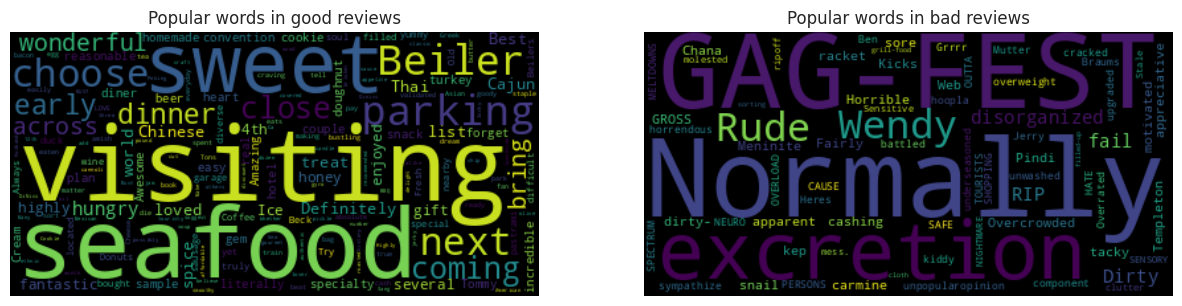

In [303]:
# Get the list of common words that are in both dictionaries
common_words = list(set(good_reviews_words.keys()) & set(bad_reviews_words.keys()))
unique_good_reviews_words = list(set(good_reviews_words.keys()) - set(common_words))
unique_bad_reviews_words  = list(set(bad_reviews_words.keys()) - set(common_words))

#Filter the dictionaries based on the list of unique words:
filtered_good_reviews_words = {k: v for k, v in good_reviews_words.items() if k in unique_good_reviews_words}
filtered_bad_reviews_words = {k: v for k, v in bad_reviews_words.items() if k in unique_bad_reviews_words}

# Get wordcloud again:
get_two_wordCloud(filtered_good_reviews_words,filtered_bad_reviews_words,
                  'Popular words in good reviews',
                 'Popular words in bad reviews')


Right! Now we actually have some words that can be distinguished between good and bad reviews

#### Bigram analysis
Here, we will use CountVectorizer from sklearn with ngram_range set to 2 for bigrams analysis

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd


def bigram_extractor(list_of_texts):
    vectorizer = CountVectorizer(ngram_range=(2, 2),stop_words='english',min_df=0)
    # Fit the model to the data and transform it into a matrix of bigrams
    bigram_matrix = vectorizer.fit_transform(list_of_texts)
    # Get the list of bigrams:
    bigram_words= vectorizer.get_feature_names_out()
    #Calculate the frequency of each bigram
    bigram_counts = np.array(bigram_matrix.sum(axis=0).flat)
    #Convert to pd dataframe:
    df_bigrams = pd.DataFrame([bigram_words, bigram_counts]).transpose()
    df_bigrams.columns = ['words','frequency']
    df_bigrams.sort_values(by='frequency', ascending=False,inplace=True)
    return df_bigrams

In [378]:
good_reviews_bigrams= bigram_extractor(RTMarket_rating[RTMarket_rating['rating_label'] ==1]['text'])
bad_reviews_bigrams= bigram_extractor(RTMarket_rating[RTMarket_rating['rating_label'] ==0]['text'])

In [383]:
good_reviews_bigrams.head()

,words,frequency
80248,reading terminal,1494
98514,terminal market,950
49083,ice cream,638
43882,great place,427
58655,love place,344


In [384]:
bad_reviews_bigrams.head()

,words,frequency
2481,reading terminal,21
3090,tourist trap,12
3001,terminal market,10
1048,food court,7
1410,ice cream,7


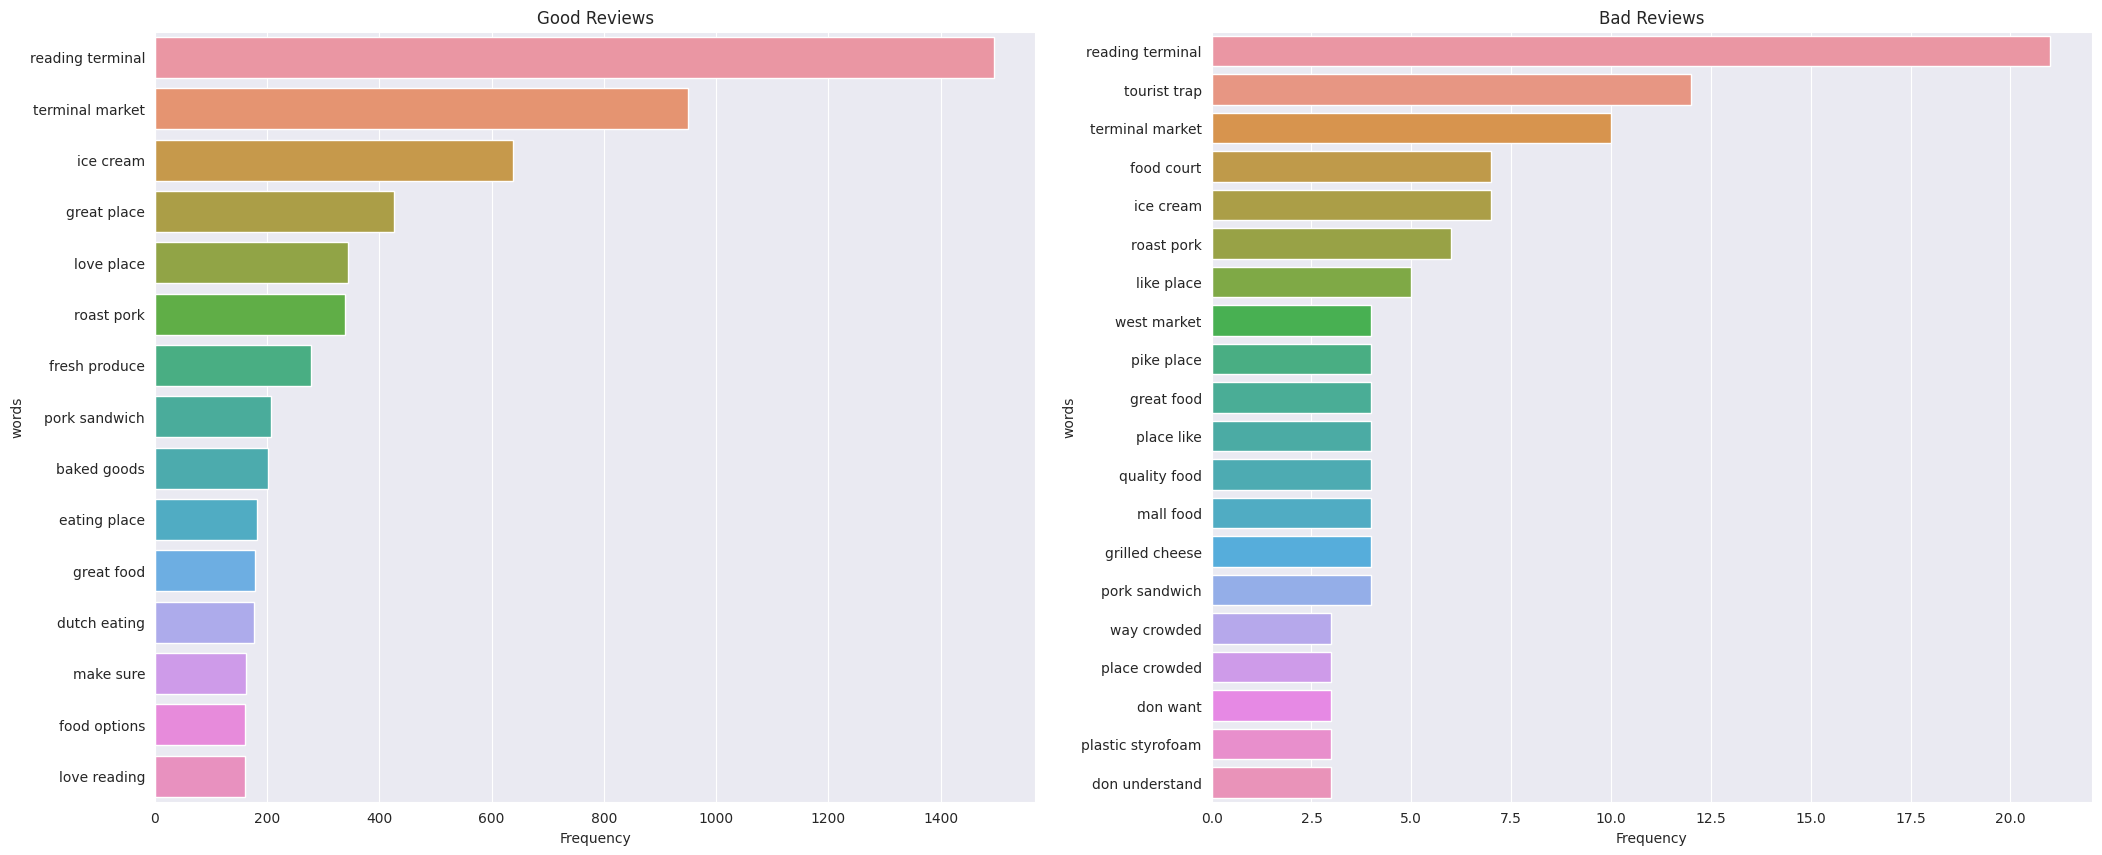

In [403]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Create the first barplot
sns.barplot(data = good_reviews_bigrams[0:15], x='frequency', y='words', ax=ax1)

# Add labels to the first plot
ax1.set_title("Good Reviews")
ax1.set_xlabel("Frequency")


# Create the second barplot
sns.barplot(data = bad_reviews_bigrams[0:20], x='frequency', y='words', ax=ax2)

# Add labels to the second plot
ax2.set_title("Bad Reviews")
ax2.set_xlabel("Frequency")

# Show the plot
plt.show()




### Perform sentiment analysis on pizza restaurants in Philadelphia

#### Get the reviews and ratings for all pizza restaurants in Philadelphia that are still open until today

In [22]:
query = f"""
            SELECT b.categories, 
                   b.name,
                   r.text,
                   CASE 
                       WHEN r.stars >=4 THEN 1
                       ELSE 0
                    END as sentiment
            FROM {bq_dir}.business b
            INNER JOIN {bq_dir}.reviews r
            ON b.business_id = r.business_id
            WHERE city = 'Philadelphia'
            AND is_open = 1
            AND lower(categories) LIKE '%pizza%' 
            AND not r.stars = 3
    """
pizza = bq.query(query = query).to_dataframe()
pizza.head()

,categories,name,text,sentiment
0,"Burgers, Italian, Restaurants, Pizza, Breakfas...",Isabella Pizza,We order pizza every Sunday and sometimes in t...,0
1,"Bars, Dive Bars, Pizza, Nightlife, Restaurants",Smokey Joe's Tavern,Ok bar if it's not filled with corny upenn stu...,0
2,"Salad, Restaurants, Coffee & Tea, Pizza, Food",Founded Coffee & Pizza,First time ordering from here... to give a cus...,0
3,"Cheesesteaks, Restaurants, Sandwiches, Pizza, ...",Abner's Cheesesteaks,Okay just as others I went off reviews. The ch...,0
4,"Sandwiches, Restaurants, Pizza, American (Trad...",Allegro Pizza,"Food is solid and not too expensive. However, ...",0


In [23]:
pizza.shape

(44549, 4)

#### Get popular words for good and bad reviews

In [30]:
#tokenized the text
pizza['processed_text']=pizza['text'].apply(lambda x: tokenize_words(x,stopwords,punctuation_regex))
pizza['processed_text'][0:3]

0    [order, pizza, every, Sunday, sometimes, middl...
1    [Ok, bar, filled, corny, upenn, student, n't, ...
2    [First, time, ordering, give, customer, order,...
Name: processed_text, dtype: object

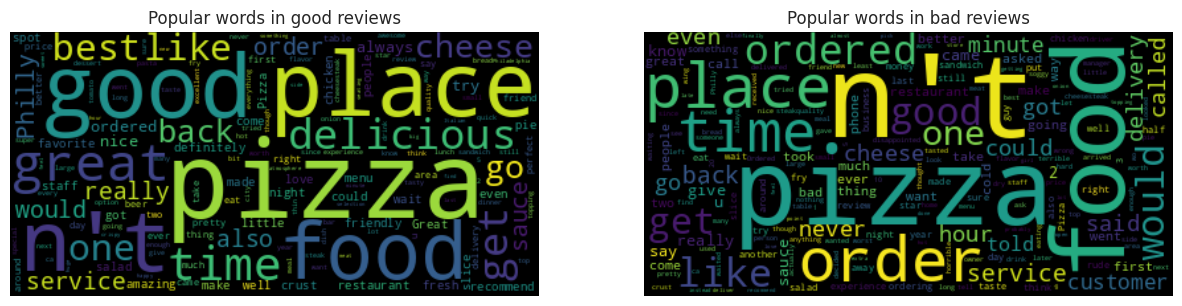

In [34]:
# Get the texts of bad and good reviews separately
bad_reviews=pizza[pizza['sentiment'] ==0]['processed_text']
good_reviews = pizza[pizza['sentiment'] ==1]['processed_text']

# Convert text in each reviews to single words (monograms) and obtain its frequency
bad_reviews_words = get_word_counter(bad_reviews)
good_reviews_words = get_word_counter(good_reviews)

# Visualize the popular words in good and bad reviews using wordcloud
get_two_wordCloud(good_reviews_words,bad_reviews_words,
                  'Popular words in good reviews',
                 'Popular words in bad reviews')

#### Get unique popular words in good and bad reviews

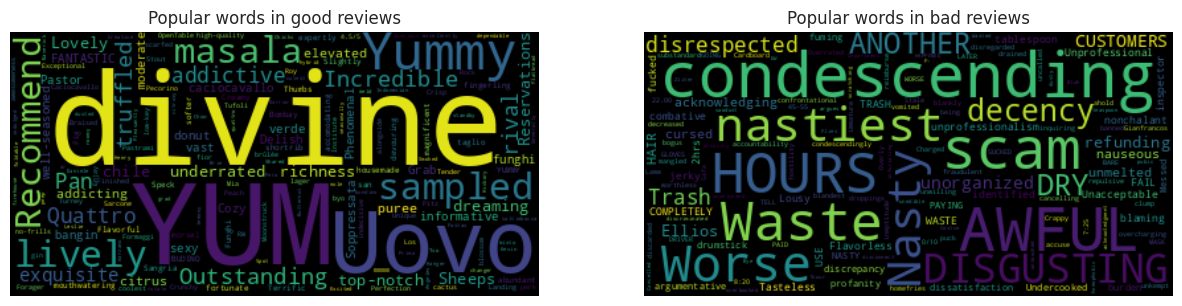

In [43]:
# Get the list of common words that are in both dictionaries
common_words = list(set(good_reviews_words.keys()) & set(bad_reviews_words.keys()))
unique_good_reviews_words = list(set(good_reviews_words.keys()) - set(common_words))
unique_bad_reviews_words  = list(set(bad_reviews_words.keys()) - set(common_words))

#Filter the dictionaries based on the list of unique words:
filtered_good_reviews_words = {k: v for k, v in good_reviews_words.items() if k in unique_good_reviews_words}
filtered_bad_reviews_words = {k: v for k, v in bad_reviews_words.items() if k in unique_bad_reviews_words}

# Get wordcloud again:
get_two_wordCloud(filtered_good_reviews_words,filtered_bad_reviews_words,
                  'Popular words in good reviews',
                 'Popular words in bad reviews')

#### Get popular phrases used in good and bad reviews for pizza places in Philadelphia

In [39]:
good_reviews_bigrams= bigram_extractor(pizza[pizza['sentiment'] ==1]['text'])
bad_reviews_bigrams= bigram_extractor(pizza[pizza['sentiment'] ==0]['text'])

In [45]:
good_reviews_bigrams.head()

,words,frequency
47678,best pizza,2205
438849,really good,1607
404238,pizza place,1399
251569,highly recommend,1358
86079,cheese steak,1146


In [41]:
bad_reviews_bigrams.head()

,words,frequency
62068,customer service,1059
44275,cheese steak,440
196126,pizza place,399
76354,don know,388
263108,tasted like,384


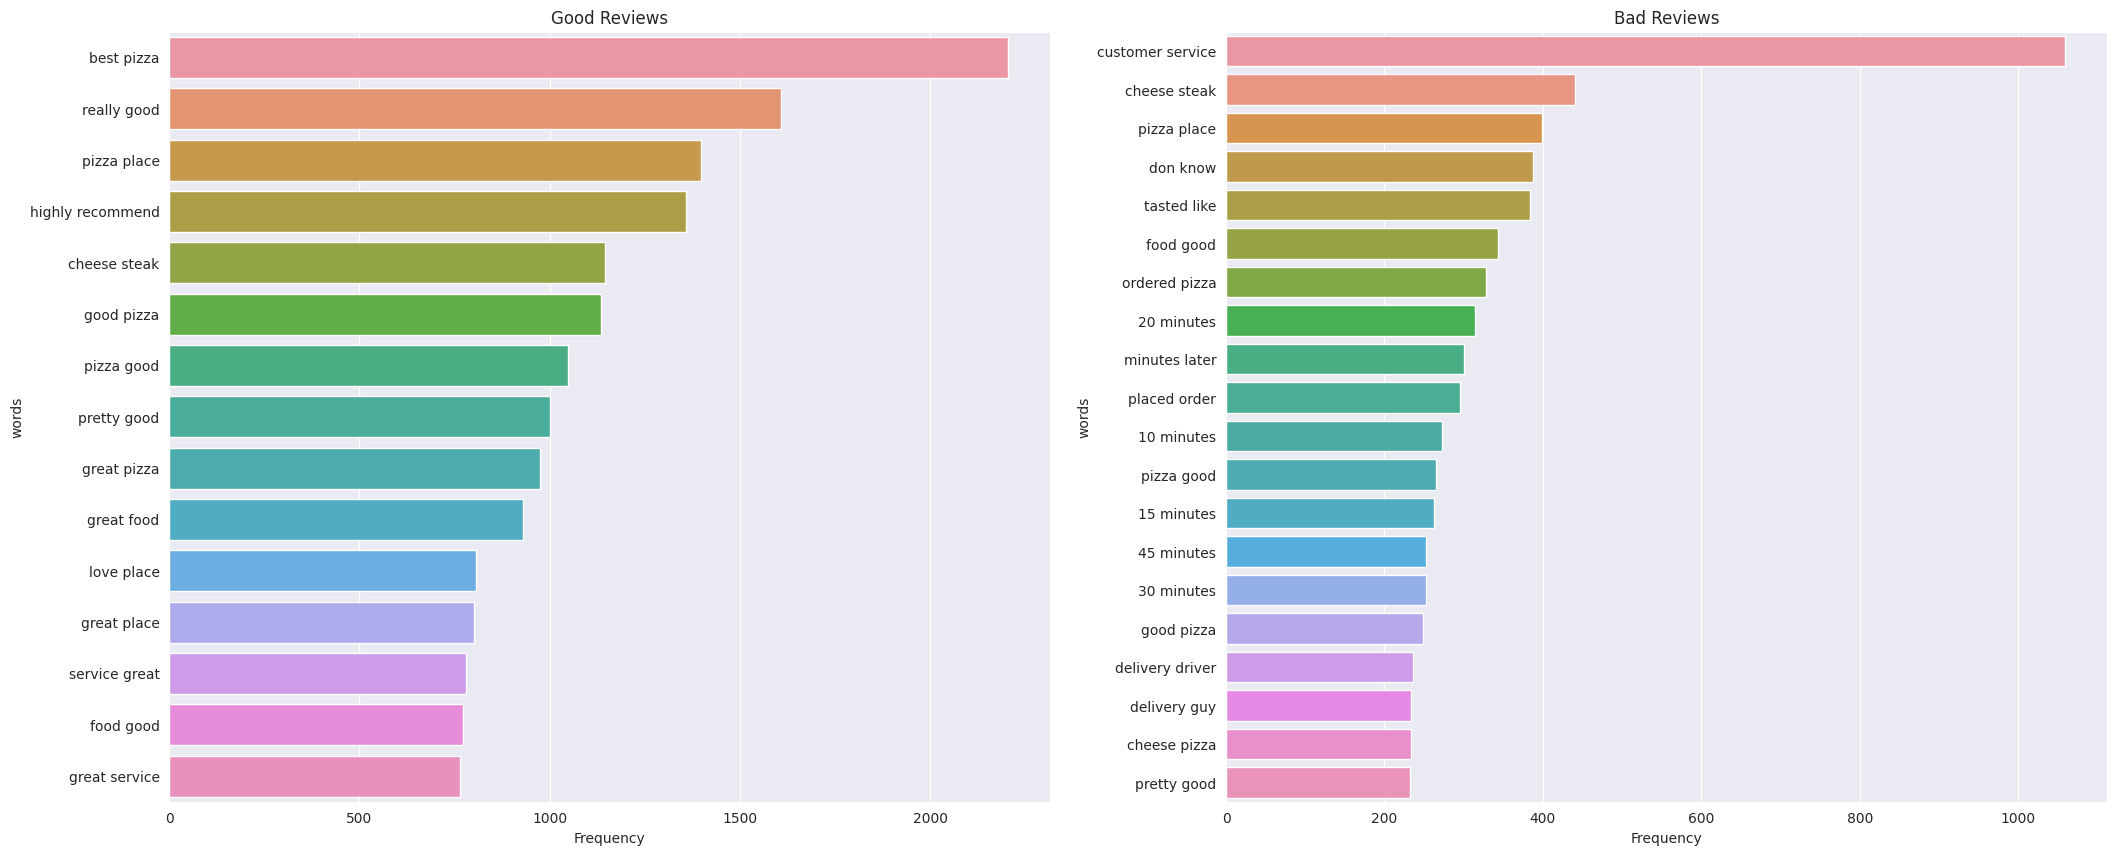

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Create the first barplot
sns.barplot(data = good_reviews_bigrams[0:15], x='frequency', y='words', ax=ax1)

# Add labels to the first plot
ax1.set_title("Good Reviews")
ax1.set_xlabel("Frequency")


# Create the second barplot
sns.barplot(data = bad_reviews_bigrams[0:20], x='frequency', y='words', ax=ax2)

# Add labels to the second plot
ax2.set_title("Bad Reviews")
ax2.set_xlabel("Frequency")

# Show the plot
plt.show()
